# Projet P5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 
Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

La segmentation proposée doit être exploitable et facile d’utilisation par notre équipe Marketing. Elle doit au minimum pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction. Nous attendons bien sûr une segmentation sur l’ensemble des clients.

Dans un deuxième temps, une fois le modèle de segmentation choisi, nous souhaiterions que vous nous fassiez une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.

Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## Etapes du projet :

Création d'une segmentation Marketing des clients et recommandation de fréquence à laquelle la segmentation doit être mise à jour.

- <b> Etape préliminaire : </b> Importation des données et description des fichiers ( --> NoteBook1 : Clustering )
- <b> Etape 1 : </b> Analyse exploratoire et feature engineering ( --> NoteBook1 : Clustering ) 
- <b> Etape 2 : </b> Elaboration d'un modèle de clustering ( --> NoteBook1 : Clustering )
- <b> Etape 3 : </b> Simulation d'évolution de la stabilité du clustering ( --> NoteBook2 : Simulation )

## Etape 3 : Simulation d'évolution de la stabilité du clustering

ETAPE 3
1. Importation des données nécessaires à la simulation
2. Construction du modèle de référence sur la période t0
3. Itération sur les périodes de temps t1, t2, etc pour évaluer la stabilité du modèle
   - construction des features sur cette période
   - (évolution de la dispersion des features)
   - Calcul du modèle
   - comparaison du ARI avec le modèle de référence

### Environnement de travail et librairies

In [6]:
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'
# Importer les autres bibliothèques après avoir défini la variable d'environnement
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as st
# from scipy.stats import ks_2samp

# Standardiser les données
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Reduction de dimensions
from sklearn import decomposition
from sklearn import manifold

# Clustering
from sklearn import cluster, metrics
# from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import silhouette_score

sns.set_palette('Set3')

### 1. Importation des données nécessaires à la simulation

In [7]:
fichiers_csv = ('olist_customers_dataset', 'olist_order_payments_dataset', 'olist_order_reviews_dataset', 'olist_orders_dataset')

# Dictionnaire pour stocker les DataFrames
dataframes = {}

for fichier in fichiers_csv:
    # Nom du fichier CSV
    csv_file = f"C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P5\\data\\{fichier}.csv"
    
    # Lire le fichier CSV
    df = pd.read_csv(csv_file)
    
    # Stocker le DataFrame dans le dictionnaire
    dataframes[fichier] = df
    
    # Afficher le nombre de lignes et de colonnes
    print(f"Le fichier {fichier} a {df.shape[1]} colonnes et {df.shape[0]} lignes")

olist_customers_dataset = dataframes['olist_customers_dataset']
olist_order_payments_dataset = dataframes['olist_order_payments_dataset']
olist_order_reviews_dataset = dataframes['olist_order_reviews_dataset']
olist_orders_dataset = dataframes['olist_orders_dataset']

Le fichier olist_customers_dataset a 5 colonnes et 99441 lignes
Le fichier olist_order_payments_dataset a 5 colonnes et 103886 lignes
Le fichier olist_order_reviews_dataset a 7 colonnes et 99224 lignes
Le fichier olist_orders_dataset a 8 colonnes et 99441 lignes


### 2. Construction du modèle de référence sur la période t0

- Reprendre les fichiers de départ et créer 1 fichier client unique sur les commandes de 01/2017 à 12/2017 :

- Construire les variables en conséquence :
    - nb_commandes depuis 01/2017 jusqua'au dernier jour de la période étudiée
    - nb_jour_reference depuis le dernier jour de la période étudiée
    - montant total des commandes depuis 01/2017 jusqua'au dernier jour de la période étudiée
    - score_min depuis 01/2017 jusqua'au dernier jour de la période étudiée
    - paiement_1fois depuis 01/2017 jusqua'au dernier jour de la période étudiée
    
- Automatisation du process dans une fonction

- Calcul du modèle sur la période t0

#### --> FONCTION : Construction d'une base de clients uniques sur une période t intégrant les variables du clustering

In [9]:
def baseClientPeriode (periode_tmin, periode_tmax):
    """ Définition de la fonction baseClientPeriode qui va :
            1. Convertir la date
            2. Filtrer les commandes sur la période t en entrée de la fonction
            3. Filtrer sur les commandes livrées
            4. Créer le référentiel client 
            5. Calculer la variable nb de commandes sur la période 
            6. Calculer la variable récence du client depuis la date référence de periode_tmax
            7. Calculer la variable montant total des commandes 
            8. Calculer la variable paiement en 1 fois 
            9. Calculer le score min de satisfaction donné par un client """
    
    # 1. Convertir la date en date_time
    olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
    # Formater la date
    olist_orders_dataset['order_purchase_dateformatee'] = olist_orders_dataset['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')
    
    # 2. Filtrer les commandes sur la période t en entrée de la fonction
    olist_orders_dataset_t = olist_orders_dataset.loc[(olist_orders_dataset['order_purchase_dateformatee'] > periode_tmin) & (olist_orders_dataset['order_purchase_dateformatee'] < periode_tmax)]
    
    # 3. Filtrer sur les commandes livrées
    olist_orders_dataset_t = olist_orders_dataset_t.loc[(olist_orders_dataset_t['order_status'] == "delivered")]
    
    # 4. Créer le référentiel client : 'order_id' x 'customer_id' x 'customer_unique_id'
    ref_order = olist_orders_dataset_t[['customer_id', 'order_id']]
    ref_customer = olist_customers_dataset[['customer_id','customer_unique_id']]
    ref_customer = pd.merge(ref_order, ref_customer, on='customer_id', how='left')
    
    # 5. Calculer la variable nb de commandes sur la période 
    # Dédoublonner la base des clients 
    ref_customer_dedup = ref_customer.drop_duplicates(subset='customer_unique_id')
    # Grouper les commandes par client et compter le nombre de commandes par client
    nb_commandes_par_client = ref_customer.groupby('customer_unique_id').size().reset_index(name='nombre_commandes')
    # Fusionnez les données des clients avec le nombre de commandes par client
    base_client_unique = pd.merge(ref_customer_dedup, nb_commandes_par_client, on='customer_unique_id', how='left')
    # Supprimer la variable customer_id qui n'a plus de sens dans cette base
    base_client_unique = base_client_unique.drop(columns=['customer_id','order_id'])
    
    # 6. Calculer la variable récence du client depuis la date référence de periode_tmax
    # Conserver uniquement les variables utiles dans olist_orders_dataset :
    olist_orders_dataset_selected = olist_orders_dataset[['order_purchase_timestamp', 'customer_id']]
    base_commandes = pd.merge(ref_customer, olist_orders_dataset_selected, on='customer_id', how='left')
    # Créer la variable date de la dernière commande
    # Triez le DataFrame par 'customer_unique_id' et 'order_date' dans l'ordre décroissant
    base_commandes = base_commandes.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'], ascending=[True, False])
    # Dédoublonner en conservant la commande la plus récente pour chaque client unique
    base_commandes_recentes = base_commandes.drop_duplicates(subset='customer_unique_id', keep='first')
    # Supprimer la variable customer_id et order_id
    base_commandes_recentes = base_commandes_recentes.drop(columns=['customer_id','order_id'])
    # Fusionnez les données des clients avec les variables créées
    base_client_unique = pd.merge(base_client_unique, base_commandes_recentes, on='customer_unique_id', how='left')
    # Convertir 'date_derniere_commande' en nombre de jours depuis une date de référence
    reference_date = pd.Timestamp(periode_tmax)  # Depuis la fin de la période d'analyse
    base_client_unique['nb_jour_reference'] = (reference_date - base_client_unique['order_purchase_timestamp']).dt.days
    base_client_unique = base_client_unique.drop(columns=['order_purchase_timestamp'])
    
    # 7. Calculer la variable montant total des commandes 
    # Fusionnez les données des clients avec les données de paiement
    # Conserver uniquement les variables utiles dans olist_order_payments_dataset :
    olist_order_payments_dataset_selected = olist_order_payments_dataset[['payment_value', 'order_id']]
    base_paiements = pd.merge(olist_order_payments_dataset_selected, ref_customer, on='order_id', how='left')
    # Sommer les valeurs de 'payment_value' pour chaque 'customer_unique_id', cela sommera d'une part les séquences d'une même commande et d'autres part les commandes d'un même client
    paiement_client_unique = base_paiements.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
    # Fusionnez avec la base_client_unique
    base_client_unique = pd.merge(base_client_unique, paiement_client_unique, on='customer_unique_id', how='left')
    # Renomer la variable 'payment_value'
    base_client_unique = base_client_unique.rename(columns={'payment_value': 'montant_total_commandes'})
    # Il y a un client pour lequel la commande n'apparait pas dans la base de paiement 
    # Remplacement des valeurs manquantes de la variable 'montant_total_commandes' par la valeur médiane :
    base_client_unique['montant_total_commandes'].fillna(base_client_unique['montant_total_commandes'].median(), inplace=True)
    
    # 8. Calculer la variable paiement en 1 fois 
    # Conserver uniquement les variables utiles dans olist_order_payments_dataset :
    olist_order_payments_dataset_selected = olist_order_payments_dataset[['payment_installments','order_id']]
    base_paiements = pd.merge(olist_order_payments_dataset_selected, ref_customer, on='order_id', how='left')
    # 2 commandes avec installments = 0 --> affecter 1
    base_paiements.loc[base_paiements["payment_installments"] == 0, "payment_installments"] = 1
    # Créer une variable 'paiement_plusieurs_fois'
    base_paiements.loc[base_paiements["payment_installments"] > 1, 'paiement_xfois'] = 1
    base_paiements.loc[base_paiements["payment_installments"] == 1, 'paiement_xfois'] = 0
    # Triez le DataFrame par 'customer_unique_id' et 'paiement_xfois' dans l'ordre décroissant
    base_paiements = base_paiements.sort_values(by=['customer_unique_id', 'paiement_xfois'], ascending=[True, False])
    # Dédoublonner en conservant la commande 'paiement_xfois' = 1 en prio pour chaque client unique
    base_paiement_xfois = base_paiements.drop_duplicates(subset='customer_unique_id', keep='first')
    # Supprimer la variable customer_id qui n'a plus de sens
    base_paiement_xfois = base_paiement_xfois.drop(columns=['customer_id','order_id','payment_installments'])
    # Fusionnez les données des clients avec base_paiement_xfois
    base_client_unique = pd.merge(base_client_unique, base_paiement_xfois, on='customer_unique_id', how='left')
    base_client_unique['paiement_xfois'] = base_client_unique['paiement_xfois'].fillna(0)
    
    # 9. Calculer le score min de satisfaction donné par un client
    # Fusionnez les données des clients avec les données commentaires
    # Conserver uniquement les variables utiles dans olist_order_reviews_dataset :
    olist_order_reviews_dataset_selected = olist_order_reviews_dataset[['review_score', 'order_id']]
    base_notes = pd.merge(olist_order_reviews_dataset_selected, ref_customer, on='order_id', how='left')
    # Note minimale pour chaque 'customer_unique_id'
    commentaires_client_unique = base_notes.groupby('customer_unique_id', as_index=False)['review_score'].min()
    # Fusionnez avec la base_client_unique
    base_client_unique = pd.merge(base_client_unique, commentaires_client_unique, on='customer_unique_id', how='left')
    # Renomer la variable 'review_score'
    base_client_unique = base_client_unique.rename(columns={'review_score': 'score_min'})
    # Remplacement des valeurs manquantes de la variable 'score_min' par la valeur moyenne :
    base_client_unique['score_min'].fillna(base_client_unique['score_min'].mean(), inplace=True)
    
    return base_client_unique

#### --> Construction de la base de clients uniques sur la période t0

In [10]:
# periode_tmin = ['2016-12-31']
# periode_tmax = ['2018-01-01']
base_client_unique_t_0 = baseClientPeriode('2016-12-31','2018-01-01')

In [11]:
base_client_unique_t_0.shape

(42136, 6)

In [12]:
base_client_unique_t_0.head()

,customer_unique_id,nombre_commandes,nb_jour_reference,montant_total_commandes,paiement_xfois,score_min
0,7c396fd4830fd04220f754e42b4e5bff,2,90,82.82,0.0,4.0
1,7c142cf63193a1473d2e66489a9ae977,1,43,72.20,0.0,5.0
2,80bb27c7c16e8f973207a5086ab329e2,1,175,175.26,1.0,4.0
3,932afa1e708222e5821dac9cd5db4cae,1,229,75.16,1.0,5.0
4,39382392765b6dc74812866ee5ee92a7,1,342,35.95,0.0,1.0


#### --> Description des données t0

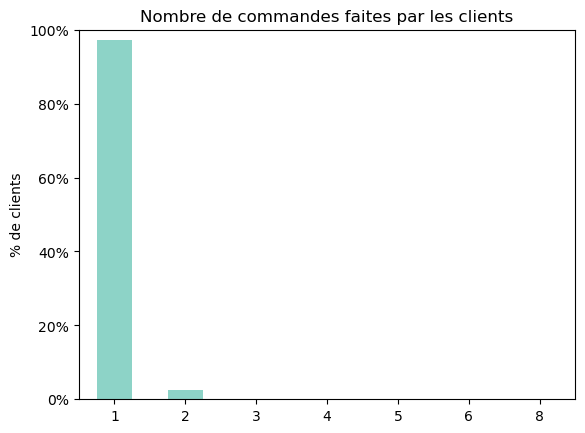

In [13]:
barplot = base_client_unique_t_0['nombre_commandes'].value_counts(normalize=True, dropna=False).plot(kind='bar')

plt.xticks(rotation=0)
plt.title("Nombre de commandes faites par les clients", fontsize=12)
plt.xlabel(None)
plt.ylabel("% de clients")
plt.ylim(0,1)
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])
        
plt.show()

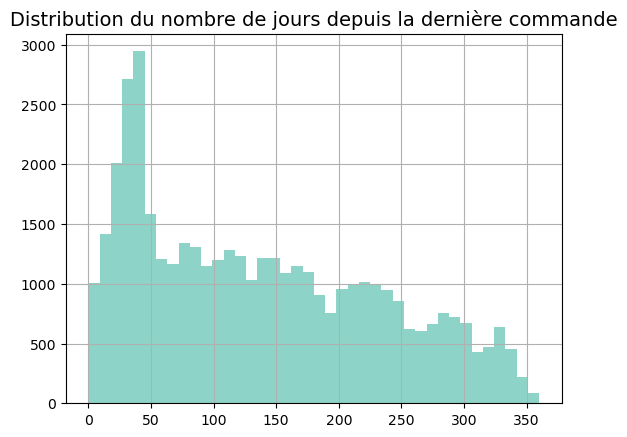

In [14]:
base_client_unique_t_0['nb_jour_reference'].hist(bins=40)
plt.title("Distribution du nombre de jours depuis la dernière commande",fontsize=14)
plt.show()

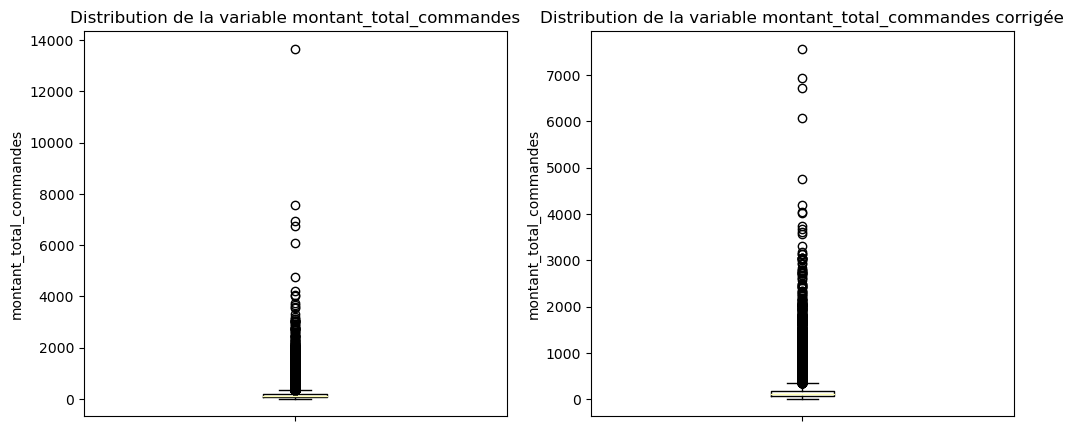

In [15]:
variable = 'montant_total_commandes'

# Supprimer les valeurs manquantes pour afficher le boxplot et étudier les outliers
df_corrige = base_client_unique_t_0.loc[base_client_unique_t_0[variable]<8000, ]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boîte à moustaches pour la distribution avant correction
axs[0].boxplot(base_client_unique_t_0[variable])
axs[0].set_title(f'Distribution de la variable {variable}')
axs[0].set_xticklabels([]) 
axs[0].set_ylabel(f"{variable}",fontsize=10) 
axs[0].ticklabel_format(style='plain', axis='y')  # Désactiver l'écriture scientifique sur l'axe y

# Boîte à moustaches pour la distribution après correction
axs[1].boxplot(df_corrige[variable])
axs[1].set_title(f'Distribution de la variable {variable} corrigée')
axs[1].set_xticklabels([]) 
axs[1].set_ylabel(f"{variable}",fontsize=10) 

plt.show()

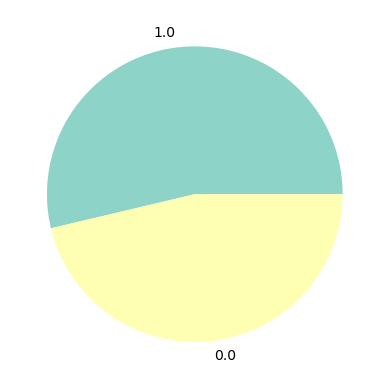

In [16]:
# Tableau récapitulatif de la variable paiement_xfois :
effectifs = base_client_unique_t_0['paiement_xfois'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['paiement_xfois']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
plt.pie(tab["n"], labels=modalites)
plt.show()

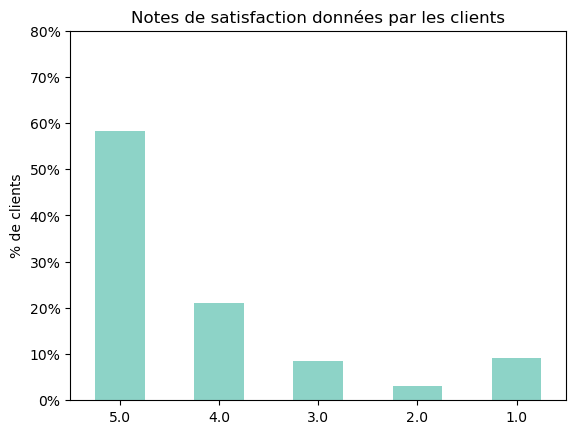

In [17]:
var = round(base_client_unique_t_0['score_min'],0)
# Calculer les fréquences relatives et les trier de 5 à 1
value_counts = var.value_counts(normalize=True, dropna=False).sort_index(ascending=False)

# Créer le diagramme en barres
barplot = value_counts.plot(kind='bar')

# Ajouter des titres et des labels
plt.xticks(rotation=0)
plt.title("Notes de satisfaction données par les clients", fontsize=12)
plt.xlabel(None)
plt.ylabel("% de clients")
plt.ylim(0, 0.8)
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])

# Afficher le diagramme
plt.show()

#### --> FONCTION : Calcul du modèle

In [18]:
def calculModele (base_client_unique_t):
    """ Définition de la fonction calculModele qui va :
            1. Supprimer les individus atypiques du dataset
            2. Normaliser les données 
            3. Appliquer le clustering K-means en 6 clusters """
    
    # 1. Supprimer les individus atypiques du dataset
    base_client_unique_t_FILT = base_client_unique_t.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
    base_client_unique_t_FILT = base_client_unique_t_FILT.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455
    # Selectionner les données 
    my_data = base_client_unique_t_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes',
                                   'score_min','paiement_xfois']]
    # 2. Normaliser les données
    # transformer les données en array numpy
    X = my_data.values
    # Centrer - réduire les données
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    
    # 3. Appliquer le clustering K-means en 6 clusters
    vars_clust = cluster.KMeans(n_clusters=6,n_init=10)
    vars_clust.fit(X_scaled)
    
    return my_data, X_scaled, vars_clust

In [19]:
my_data_M0, X_scaled_M0, vars_clust_M0 = calculModele(base_client_unique_t_0)

#### --> Visualisation du modèle sur t0

In [20]:
labels_df = pd.DataFrame(vars_clust_M0.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(6))

  labels      n          %
0   (1,)  13366  31.722599
1   (0,)  12280  29.145108
2   (2,)   9761  23.166564
3   (5,)   4773  11.328144
4   (3,)   1161   2.755494
5   (4,)    793   1.882090


In [21]:
# On ajoute la variable clusters à mon df d'orinige
my_data_M0['clusters'] = vars_clust_M0.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data_M0.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(6)

nombre_commandes                nb_jour_reference                   \
                     mean min max median              mean  min  max median   
clusters                                                                      
0                1.000000   1   1    1.0         88.645684    0  210   80.0   
1                1.000000   1   1    1.0         91.260362    0  210   86.0   
2                1.000000   1   1    1.0        266.170065  193  360  262.0   
3                2.105082   2   8    2.0        123.186908    0  360  106.0   
4                1.011349   1   2    1.0        144.915511    0  342  124.0   
5                1.000000   1   1    1.0        122.968573    0  358   97.0   

         montant_total_commandes                            score_min       \
                            mean     min       max   median      mean  min   
clusters                                                                     
0                     106.598352   10.07    761.95    77.57  4.576123  3.0   
1                     160.865032   20.08    784.07   124.96  4.573748  3.0   
2                     136.297955   12.28    783.00   101.93  4.541135  2.0   
3                     283.953609   38.24   2400.48   213.34  3.876089  1.0   
4                    1339.149962  725.81  13664.08  1124.96  4.127510  1.0   
5                     155.378598   13.17    918.31   114.07  1.249529  1.0   

                     paiement_xfois                   
          max median           mean  min  max median  
clusters                                              
0         5.0    5.0       0.000000  0.0  0.0    0.0  
1         5.0    5.0       1.000000  1.0  1.0    1.0  
2         5.0    5.0       0.536728  0.0  1.0    1.0  
3         5.0    5.0       0.668389  0.0  1.0    1.0  
4         5.0    5.0       0.742749  0.0  1.0    1.0  
5         2.0    1.0       0.557301  0.0  1.0    1.0

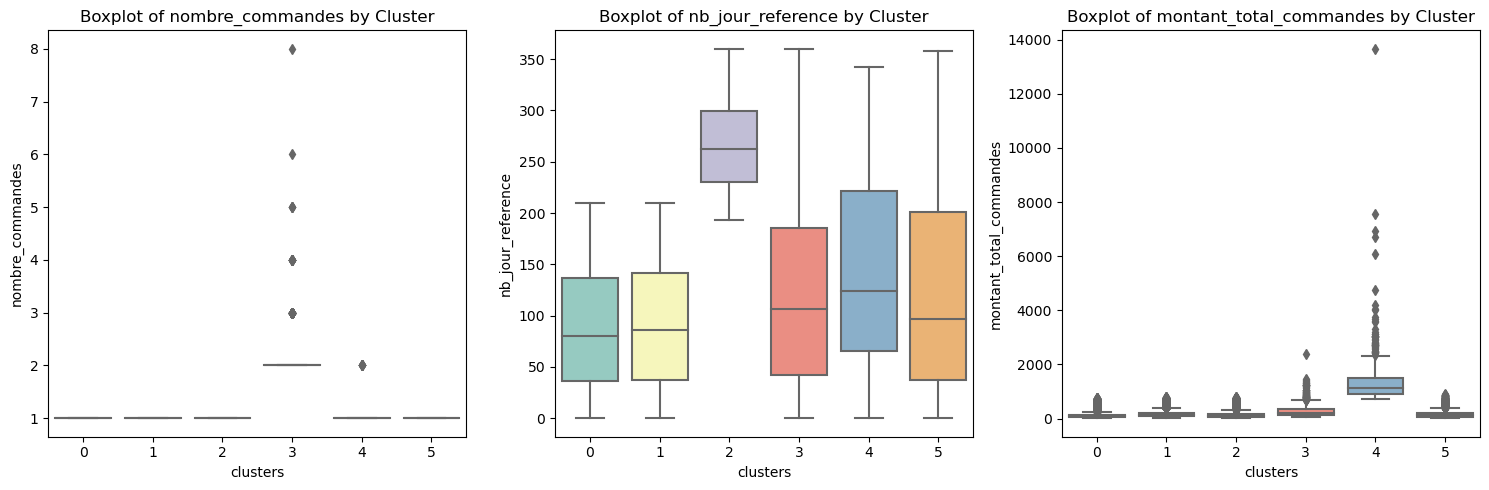

In [22]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data_M0)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

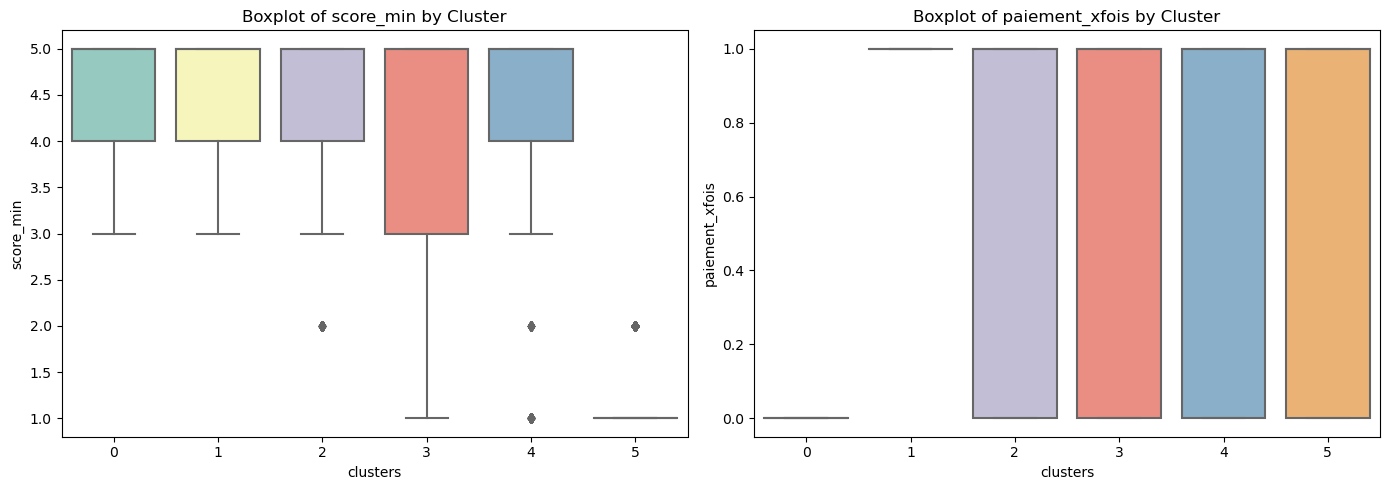

In [23]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['score_min','paiement_xfois']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data_M0)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

### 3. Itération sur les périodes de temps t1, t2, etc pour évaluer la stabilité du modèle

In [42]:
# Définir la date de début t1 (x jours)
t1 = '2018-01-15'
tn = '2018-08-31'

# Créer un Range de dates avec une fréquence de x jours
dates = pd.date_range(start=t1, end=tn, freq='7D')

# Afficher les dates au format souhaité
print(dates.strftime('%d/%m/%Y').tolist())

['15/01/2018', '22/01/2018', '29/01/2018', '05/02/2018', '12/02/2018', '19/02/2018', '26/02/2018', '05/03/2018', '12/03/2018', '19/03/2018', '26/03/2018', '02/04/2018', '09/04/2018', '16/04/2018', '23/04/2018', '30/04/2018', '07/05/2018', '14/05/2018', '21/05/2018', '28/05/2018', '04/06/2018', '11/06/2018', '18/06/2018', '25/06/2018', '02/07/2018', '09/07/2018', '16/07/2018', '23/07/2018', '30/07/2018', '06/08/2018', '13/08/2018', '20/08/2018', '27/08/2018']


In [51]:
# Itération sur les périodes de 7 jours : 

j = 0 # Initialisation d'un compteur

for i in dates:
    j += 1
    
    # 1. Fonction pour créer le dataset et les features sur la période donnée
    periode_tmin = '2016-12-31'  # Définir la date de début pour la fonction
    periode_tmax = i.strftime('%Y-%m-%d') # Définir la date de fin pour la fonction
    result = baseClientPeriode(periode_tmin, periode_tmax) 
    globals()[f'base_client_unique_t_{j}'] = result
    # print(f'base_client_unique_t_{j}:\n', globals()[f'base_client_unique_t_{j}'].shape)
    
    # 2. Calculer le modèle sur le dataset
    globals()[f'my_data_{j}'], globals()[f'X_scaled_{j}'], globals()[f'vars_clust_{j}'] = calculModele(globals()[f'base_client_unique_t_{j}'])
    
    # 3. Comparaison des distributions de deux échantillons
    ks_statistic, p_value = st.ks_2samp(globals()[f'base_client_unique_t_{j-1}']['nb_jour_reference'], globals()[f'base_client_unique_t_{j}']['nb_jour_reference'])
    print(f'KS Statistic: {ks_statistic}, p-value: {p_value}')
    
    # 4. Suivi de l'Adjusted Rand Index (ARI) pour comparer les clusters dans le temps
    # labels_previous sont les étiquettes des clusters précédents
    globals()[f'ari_{j}'] = metrics.adjusted_rand_score(vars_clust_M0.predict(globals()[f'X_scaled_{j}']), globals()[f'vars_clust_{j}'].labels_)
    print(f"Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M{j}:", round(globals()[f'ari_{j}'], 2))

KS Statistic: 0.059630662876743123, p-value: 8.60802447631496e-68
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M1: 1.0
KS Statistic: 0.044095476659232746, p-value: 3.064813978722382e-39
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M2: 1.0
KS Statistic: 0.04606763585998894, p-value: 3.0502685064273105e-44
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M3: 0.99
KS Statistic: 0.045002704288385986, p-value: 1.4702683299685128e-43
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M4: 0.99
KS Statistic: 0.04472489157441306, p-value: 2.5018747126378393e-44
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M5: 0.99
KS Statistic: 0.04332648303469222, p-value: 7.524379843900705e-43
Adjusted Rand Index entre la prédiction avec M0 et la prédiction des labels avec M6: 0.98
KS Statistic: 0.041162848123768914, p-value: 6.96278708629144

In [52]:
for i in range(1,34):
    # Résultats du clustering : 
    labels_df = pd.DataFrame(globals()[f'vars_clust_{i}'].labels_, columns=['labels'])
    effectifs = labels_df.value_counts()
    modalites = effectifs.index # l'index de effectifs contient les modalités
    tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
    tab["n"] = effectifs.values
    tab["%"] = (tab["n"]/labels_df['labels'].count())*100
    print(i, tab.head(6))

1   labels      n          %
0   (1,)  14344  31.790076
1   (2,)  13222  29.303429
2   (3,)  10334  22.902861
3   (0,)   5105  11.314022
4   (4,)   1241   2.750382
5   (5,)    875   1.939230
2   labels      n          %
0   (2,)  14821  31.691827
1   (1,)  13837  29.587735
2   (0,)  10566  22.593337
3   (3,)   5323  11.382201
4   (5,)   1295   2.769106
5   (4,)    924   1.975794
3   labels      n          %
0   (1,)  15300  31.703274
1   (2,)  14383  29.803150
2   (4,)  10769  22.314546
3   (0,)   5528  11.454621
4   (3,)   1341   2.778699
5   (5,)    939   1.945711
4   labels      n          %
0   (3,)  15653  31.451937
1   (4,)  15002  30.143868
2   (1,)  11031  22.164845
3   (0,)   5724  11.501366
4   (2,)   1388   2.788941
5   (5,)    970   1.949044
5   labels      n          %
0   (0,)  16093  31.402201
1   (1,)  15544  30.330940
2   (5,)  11225  21.903294
3   (3,)   5950  11.610209
4   (4,)   1443   2.815720
5   (2,)    993   1.937637
6   labels      n          %
0   (0,)  16600 

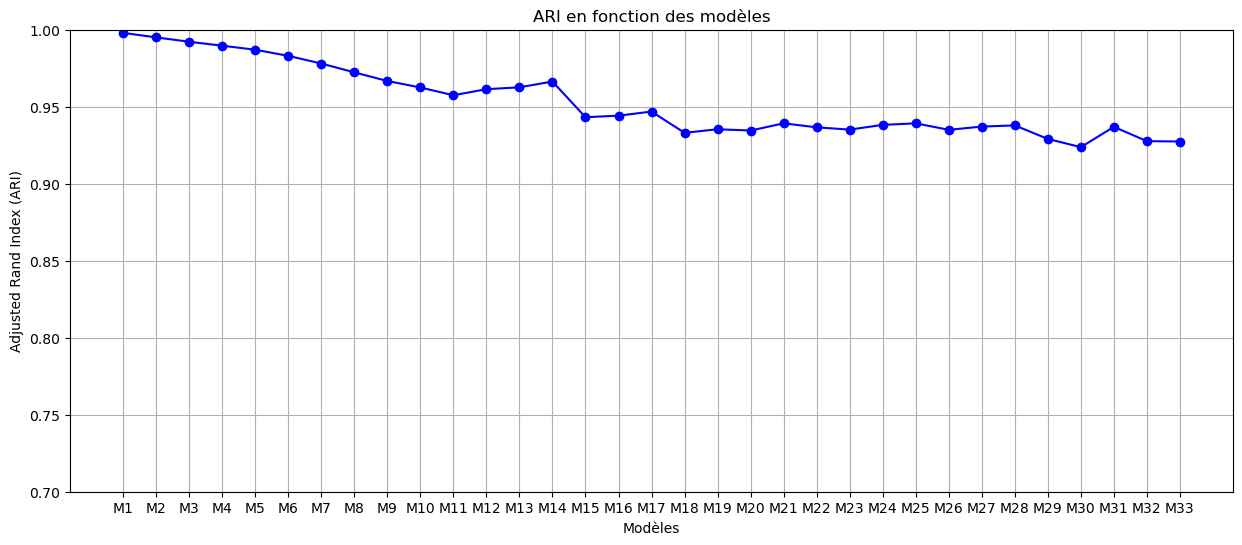

In [54]:
# Liste pour stocker les ARI
ari_values = []

# Récupération des valeurs des ARI dynamiquement
for j in range(1,34):
    ari_values.append(globals()[f'ari_{j}'])

# Générer les labels des modèles
model_labels = [f'M{j}' for j in range(1,34)]

# Tracer la courbe
plt.figure(figsize=(15, 6))
plt.plot(model_labels, ari_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et des étiquettes
plt.title('ARI en fonction des modèles')
plt.xlabel('Modèles')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.ylim(0.7, 1)  # Optionnel : pour fixer l'échelle des y entre 0 et 1
plt.grid(True)

# Afficher la courbe
plt.show()

<div class="alert alert-block alert-info">
    <b> BILAN : </b> 
    
- pour les autres, on observe une baisse légère mais constante du ARI de 1 à 0.93 en 8 mois
- en extrapolant, on passera à un ARI de 0.7 en 3 ans
- il peut arriver d'observer un ARI bas (inférieur à 0.7) sur l'un des datasets, cela peut correspondre à un modèle qui a généré des clusters différents (possible quand le modèle n'est pas stable à 100%)

</div>